In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cp /content/drive/MyDrive/100k.zip /content/100k.zip
# !unzip -q 100k.zip


Mounted at /content/drive


## 0. Import dependecies

In [2]:
import random
import numpy as np


from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import seaborn as sb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


## 1. Data preprocessing

### Define Dataset class with its methods

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_pairs = []
        self.labels = []

        # Navigate through the folders and collect image pairs
        for subdir in ['0', '1']:
            class_folder = self.root_dir / subdir
            for subfolder in class_folder.iterdir():
                image_files = list(subfolder.glob('*'))  # Collect all image files in the subfolder
                if len(image_files) == 2:  # Ensure there are exactly two images
                    self.image_pairs.append((image_files[0], image_files[1]))
                    self.labels.append(int(subdir))  # Label based on the parent folder

    def __getitem__(self, index):
        img1_path, img2_path = self.image_pairs[index]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(self.labels[index], dtype=torch.float32)

    def __len__(self):
        return len(self.image_pairs)

    def generate_pairs_and_labels(self):
        """ Generator that yields image pairs and their corresponding labels from the dataset. """
        for (img1_path, img2_path), label in zip(self.image_pairs, self.labels):
            yield (img1_path, img2_path), label

    def random_sample_info(self, seed=33):
        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)

        idx = random.randint(0, len(self.image_pairs) - 1)
        img1_path, img2_path = self.image_pairs[idx]
        label = self.labels[idx]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        print(f'Label: {label}')
        print(f'Image 1 - Path: {img1_path}, Shape: {img1.shape}, Mean: {img1.mean().item():.2f}, Std: {img1.std().item():.2f}')
        print(f'Image 2 - Path: {img2_path}, Shape: {img2.shape}, Mean: {img2.mean().item():.2f}, Std: {img2.std().item():.2f}')

    def generate_all_pairs(self):
        all_pairs = []
        for (img1_path, img2_path), label in zip(self.image_pairs, self.labels):
            all_pairs.append({'image1': img1_path, 'image2': img2_path, 'label': label})
        return all_pairs

    def print_all(self):
        for (img1_path, img2_path), label in zip(self.image_pairs, self.labels):
            print(img1_path, img2_path, label)

    def plot_random_image_pair(self, seed=42):
        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)

        # Select a random index and use __getitem__ to fetch the images
        idx = random.randint(0, len(self) - 1)
        img1, img2, label = self[idx]

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        if img1.shape[0] == 1:
            img1 = img1.squeeze(0).numpy()
            img2 = img2.squeeze(0).numpy()
            axs[0].imshow(img1, cmap='gray')
            axs[1].imshow(img2, cmap='gray')
        else:
            img1 = img1.permute(1, 2, 0).numpy()
            img2 = img2.permute(1, 2, 0).numpy()
            img1 = (img1 - img1.min()) / (img1.max() - img1.min())
            img2 = (img2 - img2.min()) / (img2.max() - img2.min())
            axs[0].imshow(img1)
            axs[1].imshow(img2)


        axs[0].set_title('Image 1')
        axs[0].axis('off')


        axs[1].set_title('Image 2')
        axs[1].axis('off')

        plt.suptitle(f'Label: {label.item()}')
        plt.show()


### Create transformator and class instance

In [4]:
transform = transforms.Compose([
    transforms.Resize((124, 124)),

    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5055, 0.4249, 0.3825], std=[0.2624, 0.2414, 0.2374]),

    #transforms.Grayscale(num_output_channels=1),
    #transforms.Normalize(mean=[0.4442], std=[0.2419]),
])

# Dataset & DataLoader
root_dir = "./data"
dataset = SiameseNetworkDataset(root_dir=root_dir, transform=transform)

## 2. Data split

In [13]:
seed = 777
torch.manual_seed(seed)

# Split dataset into train (70%), valid (15%), and test (15%) sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
# Check number of samples in each DataLoader
# print(f'Number of training samples: {len(train_loader.dataset)}')
# print(f'Number of validation samples: {len(valid_loader.dataset)}')
# print(f'Number of test samples: {len(test_loader.dataset)}')

# # Check a few labels from each DataLoader
# def check_labels(loader, name):
#     print(f'\n{name} labels:')
#     for batch in loader:
#         _, _, labels = batch
#         print(labels)
#         break  # Only print the first batch

# check_labels(train_loader, "Train")
# check_labels(valid_loader, "Validation")
# check_labels(test_loader, "Test")

## 3. Model

#### Euclides

In [15]:
class Euclides(nn.Module):
    def __init__(self):
        super(Euclides, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128)
        )



    def forward_one(self, x):
        x = self.cnn1(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

##### Loss

In [16]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

#### Dummy for shapes

In [ ]:
# Instantiate the model
model = Euclides()

# Create a dummy input tensor with the same dimensions as your actual input (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 124, 124)

# Pass the dummy input through the network and print the output size at each stage
def print_layer_shapes(model, dummy_input):
    x = dummy_input
    for layer in model.cnn1:
        x = layer(x)
        print(f'After layer {layer.__class__.__name__}: {x.shape}')
    x = x.view(x.size()[0], -1)
    print(f'Flattened size: {x.shape}')

# print_layer_shapes(model, dummy_input)

## 4. Init and train the model



### Init model

In [21]:
# Check if GPU is available
model = Euclides().to(device)

### Init parameters

In [22]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
criterion = ContrastiveLoss().to(device)

# Lists to store losses
train_losses = []
val_losses = []

# Early stopping variables
patience = 7  # Early stopping patience
best_val_loss = np.inf
patience_counter = 0

### Train model

In [23]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False) as pbar:
        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Forward pass
            output1, output2 = model(img1, img2)

            # Compute loss
            loss = criterion(output1, output2, label)

            # # Forward pass
            # similarity_score = model(img1, img2)
            # # Compute loss
            # loss = criterion(similarity_score, label.unsqueeze(1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            pbar.set_postfix({'train_loss': running_train_loss / (pbar.n + 1)})
            pbar.update(1)

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.inference_mode():
        for img1, img2, label in valid_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            # similarity_score = model(img1, img2)
            # loss = criterion(similarity_score, label.unsqueeze(1))
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(valid_loader)
    val_losses.append(val_loss)

    print(f'\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Patience exceeded - early stopping triggered")
        break

    scheduler.step()

print('Training complete.')


Epoch [1/10], Train Loss: 0.5070, Val Loss: 0.2982



Epoch [2/10], Train Loss: 0.2998, Val Loss: 0.2847



Epoch [3/10], Train Loss: 0.2861, Val Loss: 0.2791



Epoch [4/10], Train Loss: 0.2871, Val Loss: 0.2891



Epoch [5/10], Train Loss: 0.2721, Val Loss: 0.2650



Epoch [6/10], Train Loss: 0.2645, Val Loss: 0.2618



Epoch [7/10], Train Loss: 0.2612, Val Loss: 0.2632



Epoch [8/10], Train Loss: 0.2606, Val Loss: 0.2622



Epoch [9/10], Train Loss: 0.2568, Val Loss: 0.2609



Epoch [10/10], Train Loss: 0.2559, Val Loss: 0.2597
Training complete.


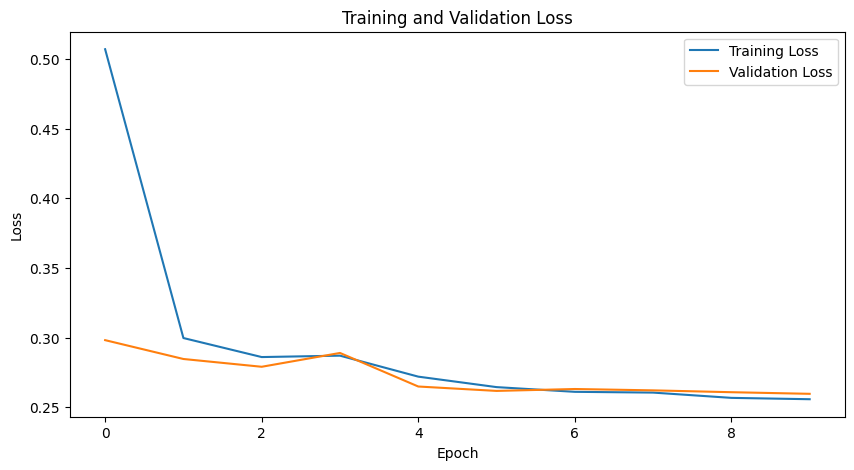

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 5. Test and show metrics

### Test model

In [43]:
# Load the best model
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()

def get_predictions_and_distances(model, dataloader):
    model.eval()
    distances = []
    labels = []
    with torch.inference_mode():
        for img1, img2, label in dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(label.cpu().numpy())

    # distances = np.concatenate(distances)
    # labels = np.concatenate(labels)
    return distances, labels

# Get predictions and distances for test data
distances, true_labels = get_predictions_and_distances(model, test_loader)
print(distances)
# Define a threshold to convert distances to binary predictions
threshold = 0.5
# predictions = (distances < threshold).astype(int)
pred_labels = [1 if dist < threshold else 0 for dist in distances]
# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')





[0.38906568, 0.577854, 0.58362174, 0.40775958, 0.38121372, 0.5171491, 0.35993153, 0.59382194, 0.6070623, 0.24032252, 0.561414, 0.43746695, 0.41025698, 0.46638563, 0.35318327, 0.43731943, 0.6813397, 0.506841, 0.46252388, 0.6241148, 0.59231377, 0.54120976, 0.62359315, 0.44358075, 0.58676803, 0.37787035, 0.61053705, 0.45551845, 0.3858605, 0.67238444, 0.56008166, 0.6518955, 0.46814016, 0.5629101, 0.46132472, 0.45433494, 0.58887976, 0.53912103, 0.52096486, 0.5500199, 0.6127665, 0.416199, 0.47432673, 0.6509376, 0.4786385, 0.48286647, 0.3960457, 0.5866346, 0.37386972, 0.5026446, 0.5464416, 0.56669575, 0.50781375, 0.4557586, 0.48419833, 0.5206841, 0.49616438, 0.4294955, 0.5976559, 0.67456114, 0.414961, 0.58302194, 0.4527947, 0.40554765, 0.53753394, 0.54918444, 0.47229946, 0.6263231, 0.48067522, 0.37492228, 0.4053806, 0.5295598, 0.63728416, 0.47321302, 0.4386928, 0.5015152, 0.52839303, 0.6790813, 0.5050188, 0.56907326, 0.38087395, 0.42559636, 0.61327535, 0.50785196, 0.44516507, 0.41570863, 0.39

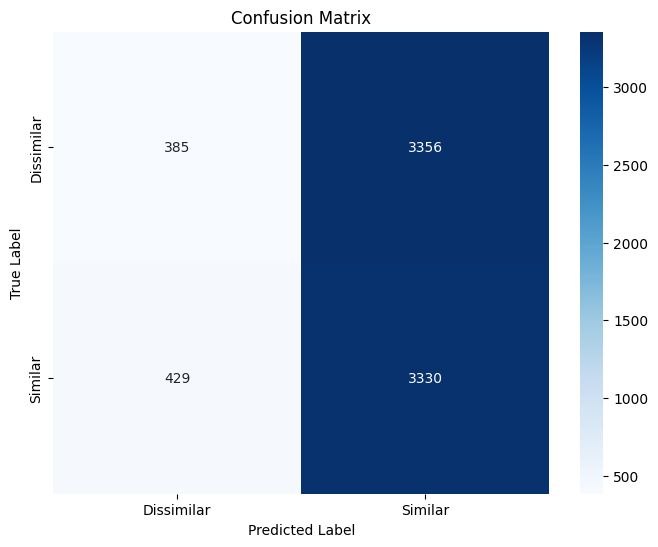

In [42]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

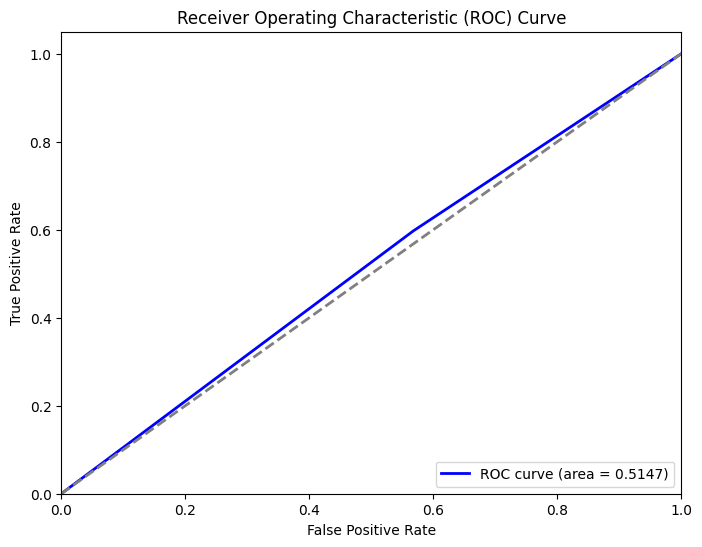

In [28]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()